```
This software is a part of GPU Ocean.

Copyright (C) 2019  SINTEF Digital

Producing plots of data-assimilation and drift trajectory forecasting 
experiments by post-processing the files produced by 
scripts/run_experiment.py

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Post Processing of Data Assimilation experiments

## Set environment

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar


import os
import sys
import datetime

from importlib import reload
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')
rc('text', usetex=True)


#Import our simulator
from SWESimulators import IPythonMagic, SimReader, Observation, ParticleInfo
from SWESimulators import DataAssimilationUtils as dautils

In [ ]:
%cuda_context_handler gpu_ctx
timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")


## Specify the folder containing the results

NB - You should match the `result_dir` with the variable `main_title`

In [ ]:
#result_dir = os.path.abspath('../../../data/ETKF_experiment_2021_01_20-09_17_20')
#result_dir = os.path.abspath('../../../data/EnKF_experiment_2020_12_17-15_34_59')
result_dir = os.path.abspath('forecasting_results/da_experiment_2021_01_26-16_02_12')


print(result_dir)

#main_title = "No data assimilation"
#main_title = "Ten drifters"
#main_title = "All drifters"
main_title = "All moorings"
#main_title = "West moorings"
#main_title = "South moorings"

truth_folder = os.path.join(result_dir, "truth")

savefigs = True

assert(os.path.isdir(result_dir)), "Directory which is supposed to contain the results does not exist"

Exception caught: Resetting to CUDA context gpu_ctx
Traceback (most recent call last):
  File "C:\Users\florianb\Miniconda3\envs\gpuocean\lib\site-packages\IPython\core\interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-1e9d87ace93c>", line 19, in <module>
    assert(os.path.isdir(result_dir)), "Directory which is supposed to contain the results does not exist"
AssertionError: Directory which is supposed to contain the results does not exist
c:\Users\florianb\Documents\GPU-Ocean\gpu-ocean\gpu_ocean\prototypes\ETKF\forecasting_results\da_experiment_2021_01_26-16_02_12


AssertionError: Directory which is supposed to contain the results does not exist

In [ ]:
def file_filter(path_to_dir, ext=None, prefix=None, abspath=True):
    filtered_files = os.listdir(path_to_dir)
    if prefix:
        filtered_files = list(file for file in filtered_files if file.startswith(prefix))
    if ext:
        filtered_files = list(file for file in filtered_files if file.endswith(ext))
    if abspath:
        filtered_files= list(os.path.join(path_to_dir, file)  for file in filtered_files)

    filtered_files.sort()
    return filtered_files


nc_files = file_filter(result_dir, ext='nc')
obs_files = file_filter(result_dir, ext='bz2', prefix='forecast')
particle_info_files = file_filter(result_dir, ext='bz2', prefix='particle_info')
print("number of nc_files:            ", len(nc_files))
print("number of obs_files:           ", len(obs_files))
print("number of particle_info_files: ", len(particle_info_files))

if False:
    print(len(nc_files), nc_files)
    print()
    print(len(obs_files), obs_files)
    print()
    print(len(particle_info_files), particle_info_files)
    
# Truth:
true_nc = truth_folder + "/double_jet_case_truth.nc"
true_obs_file = truth_folder + "/drifter_observations.pickle"
    
ensemble_size = len(nc_files)
num_drifters=64


#drifterSet = [ 4,  9, 14, 29, 33, 39, 44, 50, 56, 54]
#drifterSet = [ 4,  9, 14, 26, 31, 37, 50, 62, 54]
drifterSet = [ 2,  7, 12, 24, 29, 35, 41, 48, 53, 60]

if result_dir.find("april") > -1:
    drifterSet = [4, 12, 20, 28, 36, 44, 52, 60]
elif result_dir.find("may_buoy") > -1:
    drifterSet = [ 4,  9, 14, 29, 33, 39, 44, 50, 56, 54]

unobservedDrifterSet = [ 4,  9, 14, 26, 31, 37, 50, 62, 54]



number of nc_files:             100
number of obs_files:            0
number of particle_info_files:  200


In [ ]:
# Read netCDF files
reload(SimReader)

truth_reader = SimReader.SimNetCDFReader(true_nc)
sim_readers = [None]*ensemble_size
for particle_id in range(ensemble_size):
    if particle_id != 63:
        sim_readers[particle_id] = SimReader.SimNetCDFReader(nc_files[particle_id])

sim_readers.pop(63)


### Functions for plotting

In [ ]:
def _markDriftersInImshow(ax, observed_drifter_positions):

    for d in range(ensemble.getNumDrifters()):
        cell_id_x = int(np.floor(observed_drifter_positions[d,0]/ensemble.getDx()))
        cell_id_y = int(np.floor(observed_drifter_positions[d,1]/ensemble.getDy()))
        circ = matplotlib.patches.Circle((cell_id_x, cell_id_y), 2, fill=False)
        ax.add_patch(circ)

def imshow(im, interpolation="None", title=None, figsize=(4,4), interior=False):
    fig = plt.figure(figsize=figsize)
    
    if interior:
        im = plt.imshow(im[2:-2,2:-2], interpolation=interpolation, origin='lower')
    else:
        im = plt.imshow(im, interpolation=interpolation, origin='lower')
    
    plt.colorbar()
    if title is not None:
        plt.title(title)
        
def imshow3(eta, hu, hv, interpolation="None", title=None, figsize=(12.5,3.4), # (12.5, 3.4)
            color_bar_from_zero=False, save_filename=None, constant_range=False, pretitle='',
            mark_drifter_positions = None):
    
    fig, axs = plt.subplots(1,3, figsize=figsize)
    
    #fig = plt.figure(figsize=figsize)

    #gs = fig.add_gridspec(1,10)#, sharey=True)
    #axs = [None, None, None]
    #axs[0] = fig.add_subplot(gs[0, 1:4])
    #axs[1] = fig.add_subplot(gs[0, 4:7])
    #axs[2] = fig.add_subplot(gs[0, 7:10])
    
    eta_max = np.max(np.abs(eta))
    huv_max = max(np.max(np.abs(hu)), np.max(np.abs(hv)))
    
    if constant_range:
        eta_max = 3.5
        huv_max = 625
    
    eta_cmap = 'BrBG'
    huv_cmap = 'RdBu'
    
    eta_min = -eta_max
    huv_min = -huv_max
    if color_bar_from_zero:
        eta_min, huv_min = 0, 0
        if constant_range:
            eta_max = 0.12
            huv_max = 50
        
        eta_cmap = 'BuGn'
        huv_cmap = 'Blues'
        
    nx = truth_reader.get('nx')
    ny = truth_reader.get('ny')
    dx = truth_reader.get('dx')
    dy = truth_reader.get('dy')
    extent=np.array([0, nx*dx, 0, ny*dy]) / 1000
    
    
    fontsize = 18
    def addColorbar(ax, im, title):
        ax_divider = make_axes_locatable(ax)
        ax_cb = ax_divider.append_axes("top", size="10%", pad="5%")
        cbar = colorbar(im, cax=ax_cb, orientation="horizontal")
        ax_cb.xaxis.set_ticks_position("top")
        ax_cb.set_title(title, fontsize=fontsize)
    
    eta_im = axs[0].imshow(eta, interpolation=interpolation, origin='lower', 
                           vmin=eta_min, vmax=eta_max, extent=extent, cmap=eta_cmap) #GnBu')
    addColorbar(axs[0], eta_im, pretitle+"$\eta$ [m]")
    
    hu_im = axs[1].imshow(hu, interpolation=interpolation, origin='lower', 
                          vmin=huv_min, vmax=huv_max, extent=extent, cmap=huv_cmap)
    addColorbar(axs[1], hu_im, pretitle+"$hu$ [m$^2$/s]")
    
    
    hv_im = axs[2].imshow(hv, interpolation=interpolation, origin='lower',
                          vmin=huv_min, vmax=huv_max, extent=extent, cmap=huv_cmap)
    addColorbar(axs[2], hv_im, pretitle+"$hv$ [m$^2$/s]")
    
    axs[0].set_ylabel(main_title, labelpad=3, fontsize=fontsize)

    if mark_drifter_positions is not None:
        mark_drifter_positions[:,0] = mark_drifter_positions[:,0]*ensemble.dx/1000
        mark_drifter_positions[:,1] = mark_drifter_positions[:,1]*ensemble.dy/1000
        _markDriftersInImshow(axs[1], mark_drifter_positions)
        _markDriftersInImshow(axs[2], mark_drifter_positions)
    
    #for ax in axs:
    #    ax.set_xlabel("$x$ [km]")
    #    ax.set_ylabel("$y$ [km]")
    
    if title is not None:
        plt.suptitle(r"\textbf{"+title+"}", y=1.1) #, fontsize=14)
    #plt.tight_layout()
    
    if save_filename is not None and savefigs:
        fig.savefig(result_dir + "/" + save_filename + ".png", bbox_inches='tight')
        fig.savefig(result_dir + "/" + save_filename + ".pdf", bbox_inches='tight')
        
        
    
def days_to_sec(days):
    return days*24*60*60

def sec_to_days(secs):
    return secs/(24*60*60)

def truth_time_step(t):
    t = t - days_to_sec(3)
    return int(t/(60*60))

In [ ]:
## Quiver plot for day 10
def make_quiver(hu, hv, eta, save_filename=None):
    H = truth_reader.getH().max()
    day =10
    #print(dx, dy)

    u = hu/(H + eta)
    v = hv/(H + eta)

    dx, dy = truth_reader.get('dx'), truth_reader.get('dy')

    velocity = np.sqrt(u*u + v*v)

    #print(u.shape)
    frequency_x = 20
    frequency_y = 20
    x = np.arange(0, 500, frequency_x)*dx/1000
    y = np.arange(0, 300, frequency_y)*dy/1000
    u = u[::frequency_y, ::frequency_x]
    v = v[::frequency_y, ::frequency_x]
    #print(u.shape)

    velocity_quiver = velocity[::frequency_y, ::frequency_x]

    #plt.quiver(x, y, u, v, velocity_quiver)

    fig = plt.figure(figsize=(5,3))
    ax = plt.subplot(111)
    im = ax.imshow(velocity, cmap=plt.cm.Oranges, extent=[0, x[-1], 0, y[-1]], origin='lower', vmax=3, vmin=0)
    quiv = ax.quiver(x, y, u, v)
    ax.set_title('Mean ocean currents [m/s] day '+str(day), fontsize=15)
    plt.suptitle(r"\textbf{"+main_title+"}", y=1.1) #, fontsize=14)

    cb = plt.colorbar(im)
    
    if save_filename is not None and savefigs:
        fig.savefig(result_dir + "/" + save_filename + ".png", bbox_inches='tight')
        fig.savefig(result_dir + "/" + save_filename + ".pdf", bbox_inches='tight')
    

# Mean and variance for different timesteps

In [ ]:
# Printing the timestamps for particle zero:
example_sim_reader = sim_readers[0]
times = example_sim_reader.getTimes()
print(sec_to_days(times.data))
print('Hopefully these values are only full days')


[3.         4.         5.         5.77986111]
Hopefully these values are only full days


In [ ]:

    
def plotStatisticalFields(t, truth_reader, sim_readers, save=True):

    day_string = str(int(sec_to_days(t))).zfill(2)
    print('plotting statistical features at day ' + day_string)
    
    
    # Read true state
    true_eta, true_hu, true_hv, t_tmp = truth_reader.getStateAtTime(t)
    #imshow3(true_eta, true_hu, true_hv, title='True state after ' + str(sec_to_days(t)) + ' days')
    
    depth = truth_reader.getH()[0,0]
    max_true_velocity = np.max(np.sqrt(true_hu*true_hu + true_hv*true_hv)/depth)
    print('   max true velocity: ' + str(max_true_velocity))
    
    # Allocate buffer for ensemble mean
    mean_eta, mean_hu, mean_hv = np.zeros_like(true_eta), np.zeros_like(true_hu), np.zeros_like(true_hv)
    # Allocate buffer for ensemble variance
    var_eta, var_hu, var_hv = np.zeros_like(true_eta), np.zeros_like(true_hu), np.zeros_like(true_hv)
    # Allocate buffer for mean ensemble deviation from true state
    error_eta, error_hu, error_hv = np.zeros_like(true_eta), np.zeros_like(true_hu), np.zeros_like(true_hv)
    
    # Allocate buffer for root mean square error from the truth
    rmse_eta, rmse_hu, rmse_hv = np.zeros_like(true_eta), np.zeros_like(true_hu), np.zeros_like(true_hv)
    actual_ensemble_size = 0
    for particle in sim_readers:
        try:
            eta, hu, hv, t_tmp = particle.getStateAtTime(t)
            if np.any(np.isnan(eta)):
                print("Found nan for particle " + str(actual_ensemble_size))
                raise RuntimeError()
            mean_eta += eta
            mean_hu += hu
            mean_hv += hv
            error_eta += (eta - true_eta)
            error_hu += (hu - true_hu)
            error_hv += (hv - true_hv)
            #var_eta += eta*eta
            #var_hu += hu*hu
            #var_hv += hv*hv
            actual_ensemble_size += 1
        except RuntimeError:
            pass
            # Ignore not found RuntimeError
    mean_eta /= actual_ensemble_size
    mean_hu /= actual_ensemble_size
    mean_hv /= actual_ensemble_size
    
    #var_eta = var_eta/actual_ensemble_size - mean_eta*mean_eta
    #var_hu  = var_hu/actual_ensemble_size -mean_hu*mean_hu
    #var_hv  = var_hv/actual_ensemble_size -mean_hv*mean_hv
    
    title = main_title + ': Ensemble mean after ' + str(sec_to_days(t)) + ' days'
    imshow3(mean_eta, mean_hu, mean_hv, title=title,
            save_filename='ensemble_mean_day_' + day_string, constant_range=True,
            pretitle='Ensemble mean ')
    
    make_quiver(mean_hu, mean_hv, mean_eta, save_filename='ensemble_mean_quiver_day_'+day_string)
    
    #error_eta = np.sqrt(error_eta)/(actual_ensemble_size - 1)
    #error_hu  = np.sqrt(error_hu )/(actual_ensemble_size - 1)
    #error_hv  = np.sqrt(error_hv )/(actual_ensemble_size - 1)
    error_eta = error_eta/actual_ensemble_size
    error_hu  = error_hu /actual_ensemble_size
    error_hv  = error_hv /actual_ensemble_size

    title = main_title + ': Ensemble error after ' + str(sec_to_days(t)) + ' days'
    imshow3(error_eta, error_hu, error_hv, title=title,
            save_filename='ensemble_error_day_' + day_string, constant_range=True)

    if True:
        actual_ensemble_size = 0
        for particle in sim_readers:
            try:
                eta, hu, hv, t_tmp = particle.getStateAtTime(t)
                if np.any(np.isnan(eta)):
                    print("Found nan for particle " + str(actual_ensemble_size))
                    raise RuntimeError()
                var_eta += (mean_eta - eta)**2
                var_hu += (mean_hu - hu)**2
                var_hv += (mean_hv - hv)**2
                rmse_eta += (true_eta - eta)**2
                rmse_hu  += (true_hu  -  hu)**2
                rmse_hv  += (true_hv  -  hv)**2
                actual_ensemble_size += 1
            except RuntimeError:
                pass
                # Ignore not found RuntimeError

        var_eta  = np.sqrt(var_eta )/(actual_ensemble_size - 1)
        var_hu   = np.sqrt(var_hu  )/(actual_ensemble_size - 1)
        var_hv   = np.sqrt(var_hv  )/(actual_ensemble_size - 1)
        rmse_eta = np.sqrt(rmse_eta)/(actual_ensemble_size - 1)
        rmse_hu  = np.sqrt(rmse_hu )/(actual_ensemble_size - 1)
        rmse_hv  = np.sqrt(rmse_hv )/(actual_ensemble_size - 1)
        
        title = main_title + ': Variance after ' + str(sec_to_days(t)) + ' days'        
        imshow3(var_eta, var_hu, var_hv, 
                title=title, color_bar_from_zero=True, constant_range=True,
                save_filename='ensemble_var_day_' + day_string,
                pretitle='Std.dev. ')
        
        title = main_title + ': RMSE after ' + str(sec_to_days(t)) + ' days'
        imshow3(rmse_eta, rmse_hu, rmse_hv, 
                title=title, color_bar_from_zero=True, constant_range=True,
                save_filename='ensemble_rmse_day_' + day_string,
                pretitle='Error ')


In [ ]:
#for t in times:
#    plotStatisticalFields(t, truth_reader, sim_readers)

In [ ]:
start_time = 3*24*60*60
simulation_time = start_time + 7*24*60*60
simulation_time = start_time + 2*24*60*60

true_eta, true_hu, true_hv, t_tmp = truth_reader.getStateAtTime(simulation_time)

observations_filename = os.path.join(truth_folder, "drifter_observations.pickle")
observations = Observation.Observation()
observations.read_pickle(observations_filename)

observed_drifter_positions_for_marking = observations.get_drifter_position(simulation_time)



/home/florianb/gpu-ocean/gpu_ocean/prototypes/ETKF/forecasting_results/da_experiment_2021_01_26-16_02_12


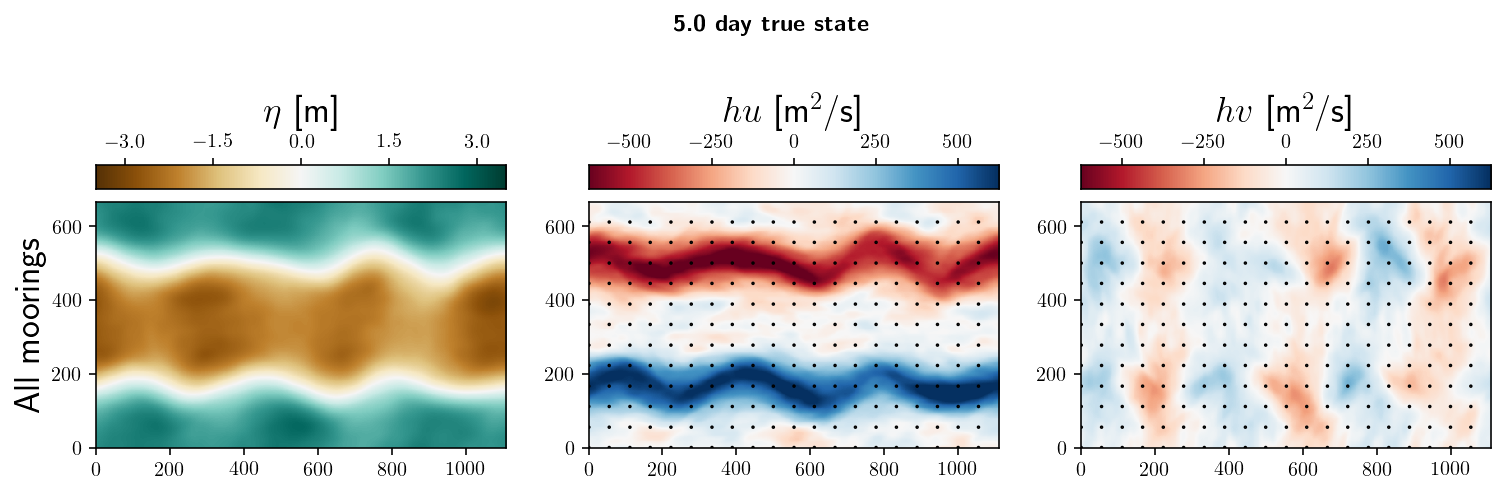

In [ ]:
imshow3(true_eta, true_hu, true_hv, title=str(sec_to_days(simulation_time))+' day true state', constant_range=True,
        save_filename='true_state_day_10', mark_drifter_positions = observed_drifter_positions_for_marking)


print(result_dir)

plotting statistical features at day 05
   max true velocity: 3.4233837


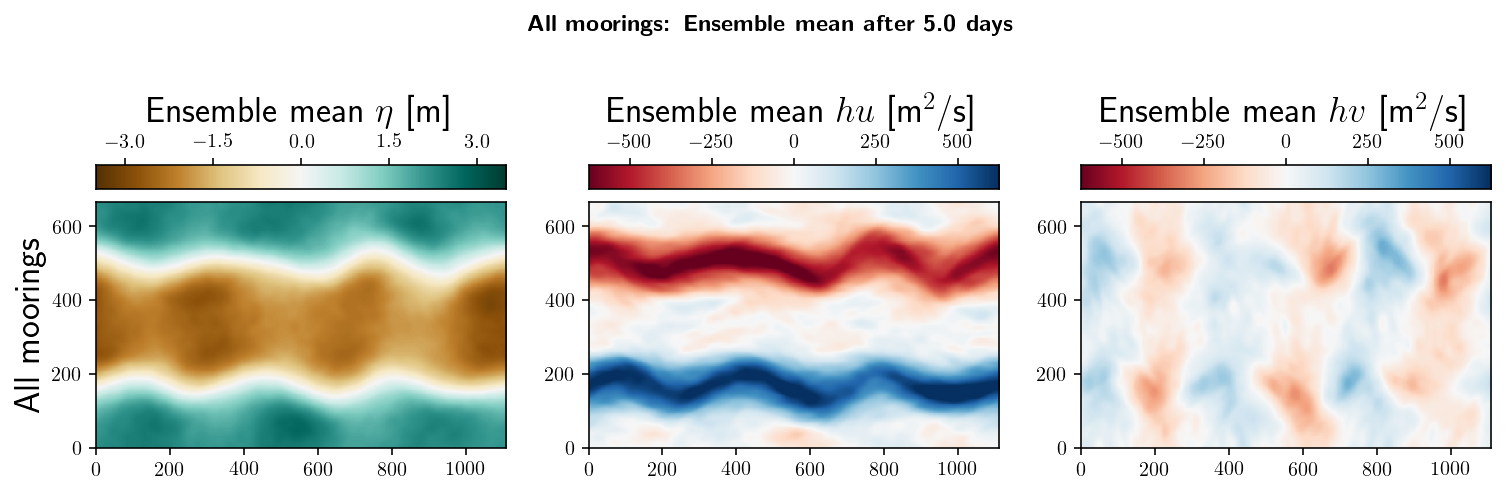

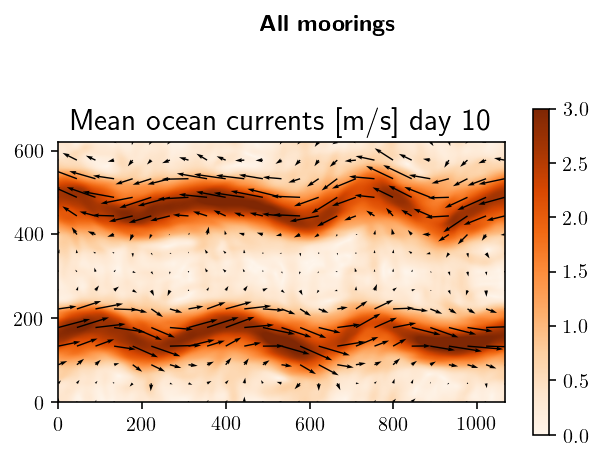

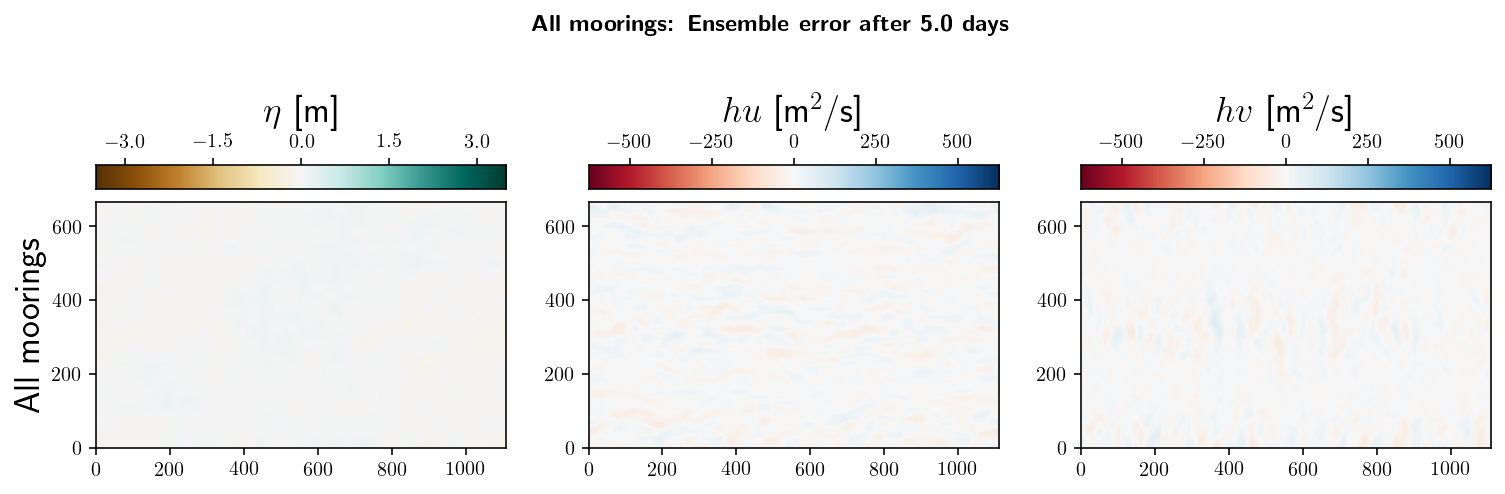

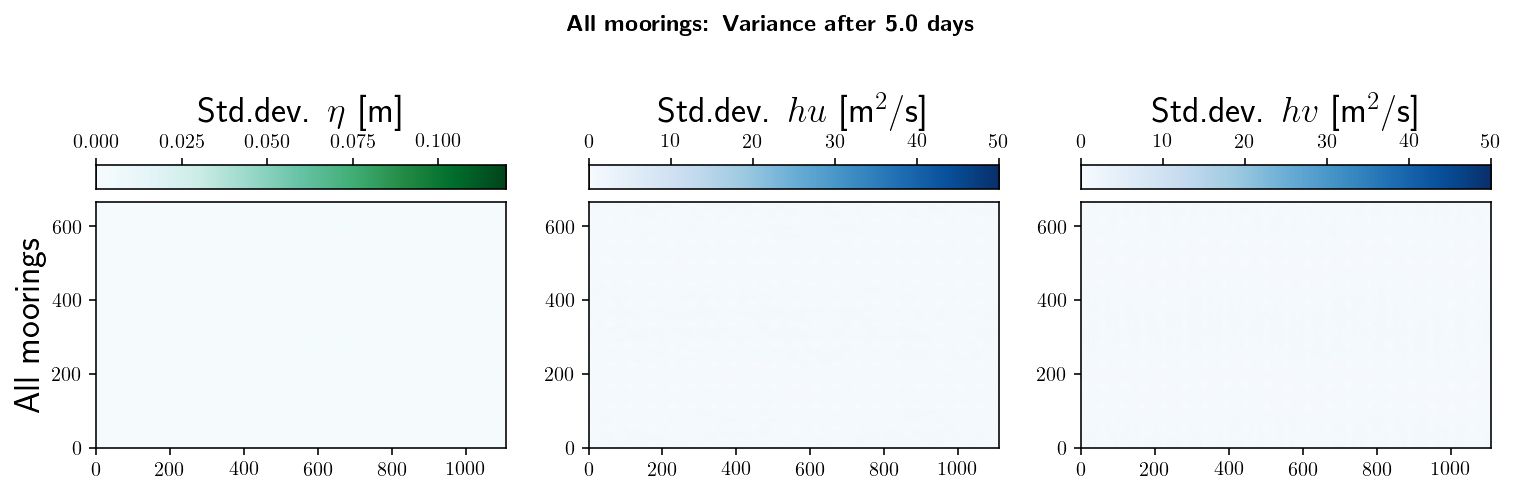

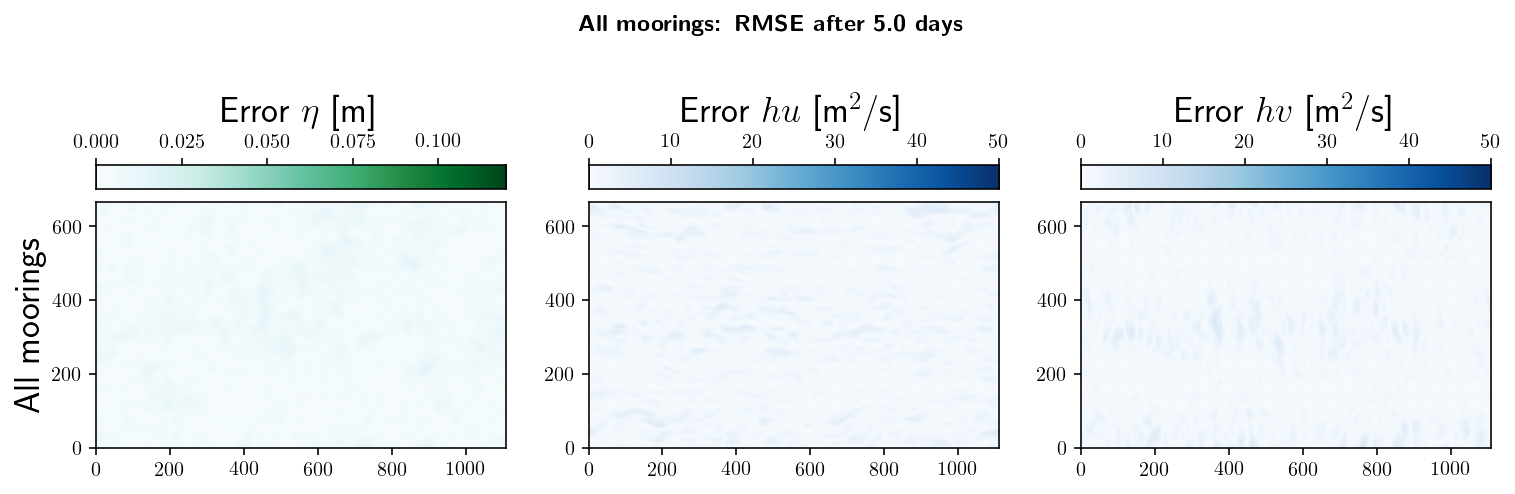

In [ ]:
plotStatisticalFields(simulation_time, truth_reader, sim_readers)

In [ ]:
crash

Exception caught: Resetting to CUDA context gpu_ctx
Traceback (most recent call last):
  File "/home/florianb/miniconda3/envs/gpuocean/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-2a418ad8f387>", line 1, in <module>
    crash
NameError: name 'crash' is not defined


NameError: name 'crash' is not defined

# Variance under drifters

We use the following definition of the root mean square error (RMSE):
$$ RMSE = \sqrt{(H(\bar{\psi}) - y)^2}$$

And standard deviation:
$$ \sigma = \sqrt{\frac{1}{N_e-1} \sum_{i=0}^{N_e} (\psi_i - \bar{\psi})^2}$$


The RMSE is therefore only accessible for observed parameters, and at observation times.


In [ ]:
num_particles = len(nc_files)
num_days = 3

particle_infos = [None]*num_particles


skipVariancePlots = True

i = 0
for particle in range(num_particles):
    filenames = file_filter(result_dir, ext='bz2', 
                            prefix='particle_info_' + str(particle).zfill(4))
    infos = [None]*num_days
    for day in range(num_days):
        
        if not skipVariancePlots or i == 0:
            infos[day] = ParticleInfo.ParticleInfo()
            infos[day].read_pickle(filenames[day])
        if particle == 0:
            print(filenames[day])
    particle_infos[particle] = infos
    print("."+str(i)+".", end='')
    i += 1
    
    
#print(particle_infos)

In [ ]:
    
info_example = particle_infos[0][0]
print(info_example)

In [ ]:
filenames = file_filter(result_dir, ext='bz2', 
                            prefix='particle_info_' + str(0).zfill(4))
for filename in filenames:
    print(filename)
print(".........")
filenames.sort()
for filename in filenames:
    print(filename)

In [ ]:
# Read truth observation file:
observation_type = dautils.ObservationType.UnderlyingFlow

if info_example.get_num_drifters() > 64:
    observation_type = dautils.ObservationType.StaticBuoys
    
equilibrium_depth = truth_reader.getH()[0,0]
nx = truth_reader.get('nx')
ny = truth_reader.get('ny')
domain_size_x = nx*truth_reader.get('dx')
domain_size_y = ny*truth_reader.get('dy')



true_observations = Observation.Observation(observation_type=observation_type,
                                            domain_size_x=domain_size_x,
                                            domain_size_y=domain_size_y,
                                            nx=nx, ny=ny)
true_observations.read_pickle(true_obs_file)



In [ ]:
print(true_obs_file)
info_example.get_num_drifters()

In [ ]:
var_per_day = [None]*num_days

#for day in range(num_days):

sample_times = info_example.get_sample_times()

drifter_id = 4

stddev_eta_first_day = np.zeros((num_drifters,len(sample_times)))
stddev_hu_first_day = np.zeros((num_drifters,len(sample_times)))
stddev_hv_first_day = np.zeros((num_drifters,len(sample_times)))

mean_eta_first_day = np.zeros((num_drifters,len(sample_times)))
mean_hu_first_day = np.zeros((num_drifters,len(sample_times)))
mean_hv_first_day = np.zeros((num_drifters,len(sample_times)))

rmse_hu_first_day = np.zeros((num_drifters,len(sample_times)//5))
rmse_hv_first_day = np.zeros((num_drifters,len(sample_times)//5))

# How many days to skip
#skip_days = 2
skip_days = 0


for particle_id in range(num_particles):
    
    if skipVariancePlots:
        if particle_id == 0:
            print('skipping the creation of variance plots')
        break
    
    sample_file = 'particle_info_' + str(particle_id).zfill(4) + "_" + str(skip_days).zfill(2) + ".bz2"
    sample_path = os.path.join(result_dir, sample_file)
    #"particle_info_0000_06.bz2"
    
    try:

        #info = ParticleInfo.ParticleInfo()
        #info.read_pickle(sample_path)
        info = particle_infos[particle_id][skip_days]
        rmse_id = -1

        for t_id in range(len(sample_times)):

            time = sample_times[t_id] + days_to_sec(skip_days)

            state_samples = info.get_state_samples(time)
            #print('state_samples.shape: ', state_samples.shape)
            
            state_observation = None
            if (particle_id == num_particles - 1) and (time % 300 == 0):
                state_observation = true_observations.get_observation(time, equilibrium_depth)
                #print('state_observation.shape: ', state_observation.shape)
                #print(state_observation[60,:])
                #soudeihfgi
                rmse_id += 1
            

            #state_samples = particle_infos[particle_id][0].get_state_samples(sample_times[t_id])

            for drifter_id in range(num_drifters):
                mean_eta_first_day[drifter_id, t_id] += state_samples[drifter_id, 0]/num_particles
                mean_hu_first_day[drifter_id, t_id] += state_samples[drifter_id, 1]/num_particles
                mean_hv_first_day[drifter_id, t_id] += state_samples[drifter_id, 2]/num_particles

                #if state_observation is not None:
                #    rmse_hu_first_day[drifter_id, rmse_id] += (state_samples[drifter_id, 1] - state_observation[drifter_id, 2])**2
                #    rmse_hv_first_day[drifter_id, rmse_id] += (state_samples[drifter_id, 2] - state_observation[drifter_id, 3])**2
                    
                #variance_eta_first_day[drifter_id, t_id] += state_samples[drifter_id, 0]**2
                #variance_hu_first_day[drifter_id, t_id] += state_samples[drifter_id, 1]**2
                #variance_hv_first_day[drifter_id, t_id] += state_samples[drifter_id, 2]**2
                
                if state_observation is not None:
                    rmse_hu_first_day[drifter_id, rmse_id] = np.sqrt((mean_hu_first_day[drifter_id, t_id] - 
                                                                      state_observation[drifter_id, 2])**2)
                    rmse_hv_first_day[drifter_id, rmse_id] = np.sqrt((mean_hv_first_day[drifter_id, t_id] - 
                                                                      state_observation[drifter_id, 3])**2)
                
        
        print("."+str(particle_id)+".", end='')
        
        
    
    except AssertionError as ae:
        print('\nParticle ' + str(particle_id) + ' failed')
        print(ae)
        
print('')
print('Std.dev.:')
for particle_id in range(num_particles):
    
    if skipVariancePlots:
        if particle_id == 0:
            print('skipping the creation of variance plots')
        break
    try:

        info = particle_infos[particle_id][skip_days]

        for t_id in range(len(sample_times)):

            time = sample_times[t_id] + days_to_sec(skip_days)

            state_samples = info.get_state_samples(time)

            for drifter_id in range(num_drifters):
                stddev_eta_first_day[drifter_id, t_id] += (state_samples[drifter_id, 0] -
                                                           mean_eta_first_day[drifter_id, t_id])**2
                stddev_hu_first_day[drifter_id, t_id] += (state_samples[drifter_id, 1] -
                                                          mean_hu_first_day[drifter_id, t_id])**2
                stddev_hv_first_day[drifter_id, t_id] += (state_samples[drifter_id, 2] - 
                                                          mean_hv_first_day[drifter_id, t_id])**2
   
        print("."+str(particle_id)+".", end='')
        
        
    except AssertionError as ae:
        print('\nParticle ' + str(particle_id) + ' failed')
        print(ae)

if not skipVariancePlots:
    stddev_eta_first_day[drifter_id, t_id] = np.sqrt(stddev_eta_first_day/(num_particles-1))
    stddev_hu_first_day[drifter_id, t_id] = np.sqrt(stddev_hu_first_day/(num_particles-1))
    stddev_hv_first_day[drifter_id, t_id] = np.sqrt(stddev_hv_first_day/(num_particles-1))

    #mean_eta_first_day /= num_particles
    #mean_hu_first_day /= num_particles
    #mean_hv_first_day /= num_particles        

    #variance_eta_first_day = variance_eta_first_day/num_particles - mean_eta_first_day**2
    #variance_hu_first_day = variance_hu_first_day/num_particles - mean_hu_first_day**2
    #variance_hv_first_day = variance_hv_first_day/num_particles - mean_hv_first_day**2

    #rmse_hu_first_day = np.sqrt((1/num_particles)*rmse_hu_first_day)
    #rmse_hv_first_day = np.sqrt((1/num_particles)*rmse_hv_first_day)



In [ ]:
stddev_eta_first_day = np.sqrt(stddev_eta_first_day/(num_particles-1))
stddev_hu_first_day = np.sqrt(stddev_hu_first_day/(num_particles-1))
stddev_hv_first_day = np.sqrt(stddev_hv_first_day/(num_particles-1))

In [ ]:
if not skipVariancePlots:
    fig = plt.figure(figsize=(16,8))
    for drifter_id in range(0, 64, 4):
        plt.plot(sec_to_days(sample_times[4::5]), rmse_hu_first_day[drifter_id,:])
    plt.xlabel('time (days)')
    plt.ylabel('RMSE hu')
    plt.grid()
    plt.ylim([-1, 35])
    plt.plot(sec_to_days(sample_times[4::5]), np.ones_like(sec_to_days(sample_times[4::5])), ':k')
    #plt.plot(sample_times, variance_hv_first_day[4,:])
    #plt.plot(sample_times, variance_eta_first_day[4,:])
    if not skipVariancePlots and savefigs:
        if true_observations.observation_type == dautils.ObservationType.StaticBuoys:
            fig.savefig(result_dir + "/" + "rmse_buoys_day_3_hu.png")
            fig.savefig(result_dir + "/" + "rmse_buoys_day_3_hu.pdf")
        else:
            fig.savefig(result_dir + "/" + "rmse_drifters_day_3_hu.png")
            fig.savefig(result_dir + "/" + "rmse_drifters_day_3_hu.pdf")


In [ ]:
if not skipVariancePlots:
    fig = plt.figure(figsize=(16,8))
    for drifter_id in range(0, 64, 4):
        plt.plot(sec_to_days(sample_times[4::5]), rmse_hv_first_day[drifter_id,:])
    plt.xlabel('time (days)')
    plt.ylabel('RMSE hv')
    plt.grid()
    plt.ylim([-1, 35])
    plt.plot(sec_to_days(sample_times[4::5]), np.ones_like(sec_to_days(sample_times[4::5])), ':k')
    #plt.plot(sample_times, variance_hv_first_day[4,:])
    #plt.plot(sample_times, variance_eta_first_day[4,:])
    if not skipVariancePlots and savefigs:
        if true_observations.observation_type == dautils.ObservationType.StaticBuoys:
            fig.savefig(result_dir + "/" + "rmse_buoys_day_3_hv.png")
            fig.savefig(result_dir + "/" + "rmse_buoys_day_3_hv.pdf")
        else:
            fig.savefig(result_dir + "/" + "rmse_drifters_day_3_hv.png")
            fig.savefig(result_dir + "/" + "rmse_drifters_day_3_hv.pdf")


In [ ]:
if not skipVariancePlots:
    fig = plt.figure(figsize=(16,8))
    for drifter_id in range(0, 64, 4):
        plt.plot(sec_to_days(sample_times), stddev_hu_first_day[drifter_id,:])
    plt.xlabel('time (days)')
    plt.ylabel('stddev hu')
    plt.grid()
    #plt.plot(sample_times, variance_hv_first_day[4,:])
    #plt.plot(sample_times, variance_eta_first_day[4,:])
    if not skipVariancePlots and savefigs:
        if true_observations.observation_type == dautils.ObservationType.StaticBuoys:
            fig.savefig(result_dir + "/" + "stddev_buoys_day_3_hu.png")
            fig.savefig(result_dir + "/" + "stddev_buoys_day_3_hu.pdf")
        else:
            fig.savefig(result_dir + "/" + "stddev_drifters_day_3_hu.png")
            fig.savefig(result_dir + "/" + "stddev_drifters_day_3_hu.pdf")

In [ ]:
if not skipVariancePlots:
    fig = plt.figure(figsize=(16,8))
    for drifter_id in range(0, 64, 4):
        plt.plot(sec_to_days(sample_times), stddev_hv_first_day[drifter_id,:])
    plt.xlabel('time (days)')
    plt.ylabel('stddev hv')
    plt.ylim([-1, 35])
    plt.grid()

    #plt.plot(sample_times, variance_hv_first_day[4,:])
    #plt.plot(sample_times, variance_eta_first_day[4,:])
    if not skipVariancePlots and savefigs:
        if true_observations.observation_type == dautils.ObservationType.StaticBuoys:
            fig.savefig(result_dir + "/" + "stddev_buoys_day_3_hv.png")
            fig.savefig(result_dir + "/" + "stddev_buoys_day_3_hv.pdf")
        else:
            fig.savefig(result_dir + "/" + "stddev_drifters_day_3_hv.png")
            fig.savefig(result_dir + "/" + "stddev_drifters_day_3_hv.pdf")

In [ ]:
if not skipVariancePlots:
    fig = plt.figure(figsize=(16,8))
    for drifter_id in range(0, 64, 4):
        plt.plot(sec_to_days(sample_times), variance_eta_first_day[drifter_id,:])
        #plt.plot(sample_times, variance_hv_first_day[4,:])

    plt.xlabel('time (days)')
    plt.ylabel('stddev eta')
    #plt.plot(sample_times, variance_hv_first_day[4,:])
    #plt.plot(sample_times, variance_eta_first_day[4,:])
    if not skipVariancePlots and savefigs:
        if true_observations.observation_type == dautils.ObservationType.StaticBuoys:
            fig.savefig(result_dir + "/" + "stddev_buoys_day_3_eta.png")
            fig.savefig(result_dir + "/" + "stddev_buoys_day_3_eta.pdf")
        else:
            fig.savefig(result_dir + "/" + "stddev_drifters_day_3_eta.png")
            fig.savefig(result_dir + "/" + "stddev_drifters_day_3_eta.pdf")

In [ ]:
#particle_infos[0][5].state_df

# Forecasting

In [ ]:
### Function for creating forecast plot

fontsize = 18


def createForecastCanvas(true_sim_reader, num_canvases=1):
    """
    true_sim_reader: The SimReader object containing nx, ny, etc
    """   
    
    nx = true_sim_reader.get('nx')
    ny = true_sim_reader.get('ny')
    dx = true_sim_reader.get('dx')
    dy = true_sim_reader.get('dy')
    extent=np.array([0, nx*dx, 0, ny*dy])/1000
    
    emptyData =np.ma.masked_where(np.zeros((ny, nx)) > 1, 
                                      np.zeros((ny, nx)))
    
    if num_canvases == 1:
        fig = plt.figure(figsize=(7,7))
        ax = plt.subplot(111)
        
        ax.imshow(emptyData, origin="lower", 
                  extent=extent, cmap='binary')

        return ax
    
    elif num_canvases < 4:
        fig, axs = plt.subplots(1,num_canvases, figsize=(12.5,3.4)) # Used in the mean figure: figsize=(12.5,3.4)
    
        for ax in axs:
            ax.imshow(emptyData, origin="lower", 
                      extent=extent, cmap='binary')
            ax.set_ylim([0, extent[3]])
            #ax.set_ylabel("$y$ [km]")
            ax.set_xlim([0, extent[1]])
            #ax.set_xlabel("$x$ [km]")
            
        axs[0].set_ylabel(main_title, labelpad=5, fontsize=fontsize)

        return axs
    assert (num_canvases < 4), 'Function not implemented for more than 3 canvases'

def forecastPlot(ax, true_paths, ensemble_paths, color_id=0, 
                 forecast_point_size=2, truth_point_size=6, mean_paths=[None]):
    """
    ax: Axis object to draw trajectories in
    true_path: A single list of paths that represents the truth
    ensemble_paths: Multiple lists of paths that represents the forecast
    color_id: integer representing a pre-defined color combination.
    """

    color_combinations = [
        # [true color, forecast color]
        #['xkcd:dark grey blue', 'xkcd:light blue grey', 'xkcd:wine'],
        ['xkcd:scarlet', 'xkcd:light blue grey', 'xkcd:dark grey blue'],
        ['xkcd:viridian', 'xkcd:foam green']
    ]
    
    assert(color_id < len(color_combinations)), 'Invalid color_id'
    
    true_color = color_combinations[color_id][0]
    forecast_color = color_combinations[color_id][1]
    mean_color = color_combinations[color_id][2]

    # Plot forecast paths 
    for paths in ensemble_paths:
        for path in paths:
            ax.plot(path[:,0], path[:,1], color=forecast_color, alpha=0.3)
        
        # Mark end position of forecast
        end_position   = paths[-1][-1,:]
        if not np.isnan(end_position[0]) and not np.isnan(end_position[1]): 
            circ_end_forecast = matplotlib.patches.Circle((end_position[0], end_position[1]), 
                                                        forecast_point_size, 
                                                        fill=False, zorder=10,
                                                        alpha=0.7)
            ax.add_patch(circ_end_forecast)

    
    # Plot true path
    for path in true_paths:
        ax.plot(path[:,0], path[:,1], color=true_color, zorder=5)
    
    # Plot mean path
    if mean_paths[0] is not None:
        for path in mean_paths:
            ax.plot(path[:,0], path[:,1], color=mean_color, zorder=6)
    
    # Mark start and end of true path
    start_pos = true_paths[0][0,:]
    end_pos   = true_paths[-1][-1,:]
    circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                           truth_point_size,
                                           fill=False, zorder=10)
    ax.add_patch(circ_start)
    #circ_end = matplotlib.patches.Circle((end_pos[0], end_pos[1]), 
    #                                     truth_point_size,
    #                                     fill=False, zorder=10)
    #ax.add_patch(circ_end)
    ax.plot(end_pos[0], end_pos[1], 'x', color='k', zorder=11)
    
    # Mark end of mean path
    if mean_paths[0] is not None:
        #xend = matplotlib.patches.Circle((mean_paths[-1][-1,0], mean_paths[-1][-1,1]),
        #                                 truth_point_size,
        #                                 fill=False, zorder=10)
        #ax.add_patch(xend)
        ax.plot(mean_paths[-1][-1,0], mean_paths[-1][-1,1], 
                   marker='o', markeredgecolor='k', markerfacecolor=None)
        

def forceDomainSize(mean_path, truth_reader):
    
    # Domain sizes in km
    domain_size_x = truth_reader.get('nx')*truth_reader.get('dx')/1000
    domain_size_y = truth_reader.get('ny')*truth_reader.get('dy')/1000
    
    paths = []
    path = np.zeros((len(mean_path), 2))
    boundary_correction = np.array([0, 0])
    path_index = 0
    
    for i in range(0, len(mean_path)):
        
        # Check that we are still in the same correction regime
        if  mean_path[i,0] < boundary_correction[0] or \
            mean_path[i,0] > boundary_correction[0] + domain_size_x or \
            mean_path[i,1] < boundary_correction[1] or \
            mean_path[i,1] > boundary_correction[1] + domain_size_y:
            
            # Update boundary_correction
            if mean_path[i,0] < boundary_correction[0]:
                boundary_correction[0] -= domain_size_x
            elif mean_path[i,0] > boundary_correction[0] + domain_size_x:
                boundary_correction[0] += domain_size_x
            
            if mean_path[i,1] < boundary_correction[1]:
                boundary_correction[1] -= domain_size_y
            elif mean_path[i,1] > boundary_correction[1] + domain_size_y:
                boundary_correction[1] += domain_size_y
            
            # Store path in paths, and start new path
            paths.append(path[:path_index,:])
            path = np.zeros((len(mean_path), 2))
            path_index = 0
        
        # Add point to path
        path[path_index, :] = mean_path[i,:] - boundary_correction
        path_index += 1
    
    paths.append(path[:path_index, :])
    return paths

def plotThreeDayForecast(true_observations, ensemble_observations, drifter_id, drifterSet, includeMean=False):
    
    start_time_forecast = days_to_sec(10)
    try:
        start_time_forecast = ensemble_observations[0].get_observation_times()[0]
    except e:
        pass
    
    true_drifter_id = drifterSet[drifter_id]
    
    print('true_observations.get_num_drifters(applyDrifterSet=False, ignoreBuoys=True)', 
           true_observations.get_num_drifters(applyDrifterSet=False, ignoreBuoys=True))
    print('ensemble_observations[0].get_num_drifters(applyDrifterSet=False, ignoreBuoys=True)', 
           ensemble_observations[0].get_num_drifters(applyDrifterSet=False, ignoreBuoys=True))
    
    if true_observations.get_num_drifters(applyDrifterSet=False, ignoreBuoys=True) == \
       ensemble_observations[0].get_num_drifters(applyDrifterSet=False, ignoreBuoys=True):
        print('using the same drifter id')
        drifter_id = true_drifter_id
    
    axs = createForecastCanvas(truth_reader, 3)
    
    for forecast_days in range(1,4):
        title = str(forecast_days) + ' days forecast' # for drifter ' + str(true_drifter_id)
        if forecast_days == 1:
            title = str(forecast_days) + ' day forecast'
        #title = title + " (" + main_title + ")" 
        print('generating ' + title)
        end_time_forecast = start_time_forecast + days_to_sec(forecast_days)
        
        true_paths = true_observations.get_drifter_path(true_drifter_id, 
                                                        start_time_forecast,
                                                        end_time_forecast)

        forecast_paths = [None]*len(ensemble_observations)
        for i in range(len(forecast_paths)):
            forecast_paths[i] = ensemble_observations[i].get_drifter_path(drifter_id,  
                                                                          start_time_forecast,
                                                                          end_time_forecast)
        mean_paths = [None]
        if includeMean:
            mean_path = ensemble_observations[0].get_drifter_path(drifter_id,  
                                                                  start_time_forecast,
                                                                  end_time_forecast,
                                                                  keepDomainSize=False)[0]
            num_paths_in_mean = 1
            
            for i in range(1, len(ensemble_observations)):
                tmp_mean_path = ensemble_observations[i].get_drifter_path(drifter_id,  
                                                                          start_time_forecast,
                                                                          end_time_forecast,
                                                                          keepDomainSize=False)[0]
                if not np.isnan(tmp_mean_path).any():
                    mean_path += tmp_mean_path
                    num_paths_in_mean += 1
                    
            mean_path /= num_paths_in_mean
            
            # Split mean_path according to periodic boundary conditions
            mean_paths = forceDomainSize(mean_path, truth_reader)
            
        ax_id = forecast_days-1
        forecastPlot(axs[ax_id], true_paths, forecast_paths, mean_paths=mean_paths)
        #axs[ax_id].set_title(title)
        axs[ax_id].set_title(title, fontsize=fontsize)
    
    suptitle = 'Forecast drifter ' + str(true_drifter_id) + ' using ' + main_title
    plt.suptitle(suptitle, y=1.1)
    #plt.tight_layout()
    
    forecast_filename = "trajectory_forecast_drifter_" + str(true_drifter_id).zfill(2)
    if includeMean:
        forecast_filename = forecast_filename + '_mean'
    
    if savefigs:
        plt.savefig(result_dir + "/" + forecast_filename + ".png", bbox_inches='tight')
        plt.savefig(result_dir + "/" + forecast_filename + ".pdf", bbox_inches='tight')

def plotShortRangeForecast(true_observations, ensemble_observations, drifter_id, drifterSet, includeMean=False):
    
    start_time_forecast = days_to_sec(10)
    try:
        start_time_forecast = ensemble_observations[0].get_observation_times()[0]
    except e:
        pass
    
    true_drifter_id = drifterSet[drifter_id]
    
    if true_observations.get_num_drifters(applyDrifterSet=False, ignoreBuoys=True) == \
       ensemble_observations[0].get_num_drifters(applyDrifterSet=False, ignoreBuoys=True):
        drifter_id = true_drifter_id
    
    keepDomainSize = False
    axs = None
    if keepDomainSize:
        axs = createForecastCanvas(truth_reader, 3)
    else:
        fig, axs = plt.subplots(1, 3, figsize=(12.5,3.4))
    
    forecast_days_array = [0.25, 0.5, 1]
    
    #min_x = true_observations.
    for ax_id in range(3):
        
        forecast_days = forecast_days_array[ax_id]
        hours = int(24*forecast_days)
        
        title=  str(hours) + ' hour forecast' # for drifter ' + str(true_drifter_id)
        #title = title + " (" + main_title + ")" 
        print('generating ' + title)

        end_time_forecast = start_time_forecast + days_to_sec(forecast_days)
        
        true_paths = true_observations.get_drifter_path(true_drifter_id, 
                                                        start_time_forecast,
                                                        end_time_forecast,
                                                        keepDomainSize=keepDomainSize)

        forecast_paths = [None]*len(ensemble_observations)
        for i in range(len(forecast_paths)):
            forecast_paths[i] = ensemble_observations[i].get_drifter_path(drifter_id,  
                                                                          start_time_forecast,
                                                                          end_time_forecast,
                                                                          keepDomainSize=keepDomainSize)
        
        mean_path = None
        if includeMean:
            mean_path = forecast_paths[0][0].copy()
            num_mean_paths = 1
            for i in range(1, len(forecast_paths)):
                if not np.isnan(forecast_paths[i][0]).any():
                    mean_path += forecast_paths[i][0]
                    num_mean_paths += 1
            mean_path /= num_mean_paths
        
        forecastPlot(axs[ax_id], true_paths, forecast_paths,
                     truth_point_size=3, forecast_point_size=1, mean_paths=[mean_path])
        #axs[ax_id].set_title(title)
        axs[ax_id].set_title(title, fontsize=fontsize)
        #axs[ax_id].set_ylabel("$y$ [km]")
        #axs[ax_id].set_xlabel("$x$ [km]")
    
    if true_drifter_id == 24:
        axs[2].set_xlim([340, 660])
        axs[2].set_ylim([95, 370])
    #print(axs[2].get_ylim())
    for ax in axs[:2]:
        ax.set_ylim(axs[2].get_ylim())
        ax.set_xlim(axs[2].get_xlim())
    axs[0].set_ylabel(main_title, labelpad=5, fontsize=fontsize)

    suptitle = 'Forecast drifter ' + str(true_drifter_id) + ' using ' + main_title
    plt.suptitle(suptitle, y=1.1)
    #plt.tight_layout()
    
    forecast_filename = "trajectory_forecast_drifter_" + str(true_drifter_id).zfill(2) + "_short_range"
    if includeMean:
        forecast_filename = forecast_filename + '_mean'
    
    if not keepDomainSize:
        forecast_filename = "local_" + forecast_filename
    
    if savefigs:
        plt.savefig(result_dir + "/" + forecast_filename + ".png", bbox_inches='tight')
        #plt.savefig(result_dir + "/" + forecast_filename + "_dpi600.png", dpi=600)
        plt.savefig(result_dir + "/" + forecast_filename + ".pdf", bbox_inches='tight')


    
    
#plotShortRangeForecast(true_observations, ensemble_observations, 5)

In [ ]:
reload(Observation)

# Read truth observation file:
true_observations = Observation.Observation(domain_size_x=domain_size_x, 
                                            domain_size_y=domain_size_y, 
                                            nx=nx, ny=ny)
true_observations.read_pickle(true_obs_file)

# Read observation files from the ensemble:

ensemble_observations = [None]*len(obs_files)
for i in range(len(obs_files)):
    ensemble_observations[i] = Observation.Observation(domain_size_x=domain_size_x, 
                                                       domain_size_y=domain_size_y, 
                                                       nx=nx, ny=ny)
    ensemble_observations[i].read_pickle(obs_files[i])
    print("."+str(i)+".", end='')

In [ ]:
#nc_files = file_filter(result_dir, ext='nc')
#obs_files = file_filter(result_dir, ext='bz2', prefix='forecast')
#particle_info_files = file_filter(result_dir, ext='bz2', prefix='particle_info')


start_time_forecast = days_to_sec(10)
end_time_forecast = days_to_sec(11)
obs_times = true_observations.get_observation_times()

drifter_id = 0
true_drifter_id = drifterSet[drifter_id]

print("Number of obs_times: ", len(obs_times))
print("Obs interval (s) (assuming 10 days): ", (10*24*60*60)/len(obs_times))
print("Day of first obs_time:  ", sec_to_days(obs_times[0]))
print("Day of second obs_time: ", sec_to_days(obs_times[1]))
print("Day of last obs_time:   ", sec_to_days(obs_times[-1]))

print("Time diff first to second (in s):        ", obs_times[1]-obs_times[0])
print("Time diff last to second to last (in s): ", obs_times[-1]-obs_times[-2])

print("Number of relevant time steps (3 day forecast): ", 3*len(obs_times)/10)

print('\nReading true path')
true_paths = true_observations.get_drifter_path(true_drifter_id, days_to_sec(10), end_time_forecast)
print('True path obtained')


print('\nReading ' + str(len(ensemble_observations)) + ' ensemble paths')
forecast_paths = [None]*len(ensemble_observations)
for i in range(len(forecast_paths)):
    forecast_paths[i] = ensemble_observations[i].get_drifter_path(drifter_id, days_to_sec(10), end_time_forecast)
    print("."+str(i)+".", end='')


    


In [ ]:
for drifter in range(len(drifterSet)):
    plotThreeDayForecast(true_observations, ensemble_observations, 
                         drifter, drifterSet, includeMean=True)
    


In [ ]:
for drifter in range(len(drifterSet)):
    plotShortRangeForecast(true_observations, ensemble_observations, drifter, drifterSet, includeMean=True)

In [ ]:
for drifter in range(len(unobservedDrifterSet)):
    plotThreeDayForecast(true_observations, ensemble_observations, drifter, 
                         unobservedDrifterSet, includeMean=True)

In [ ]:
for drifter in range(len(unobservedDrifterSet)):
    plotShortRangeForecast(true_observations, ensemble_observations, drifter, 
                           unobservedDrifterSet, includeMean=True)